In [8]:
%run flow_tools.py

In [9]:
folder= box_dir + "BadIdea/Flow/20201026 - 46,2f,47 Triplicate No 2/"

In [10]:
df = load_data(folder, colnames=["WellName", "CellLine","Treatment","Dose", 'Replicate'])
df2 = clean_data(df)

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


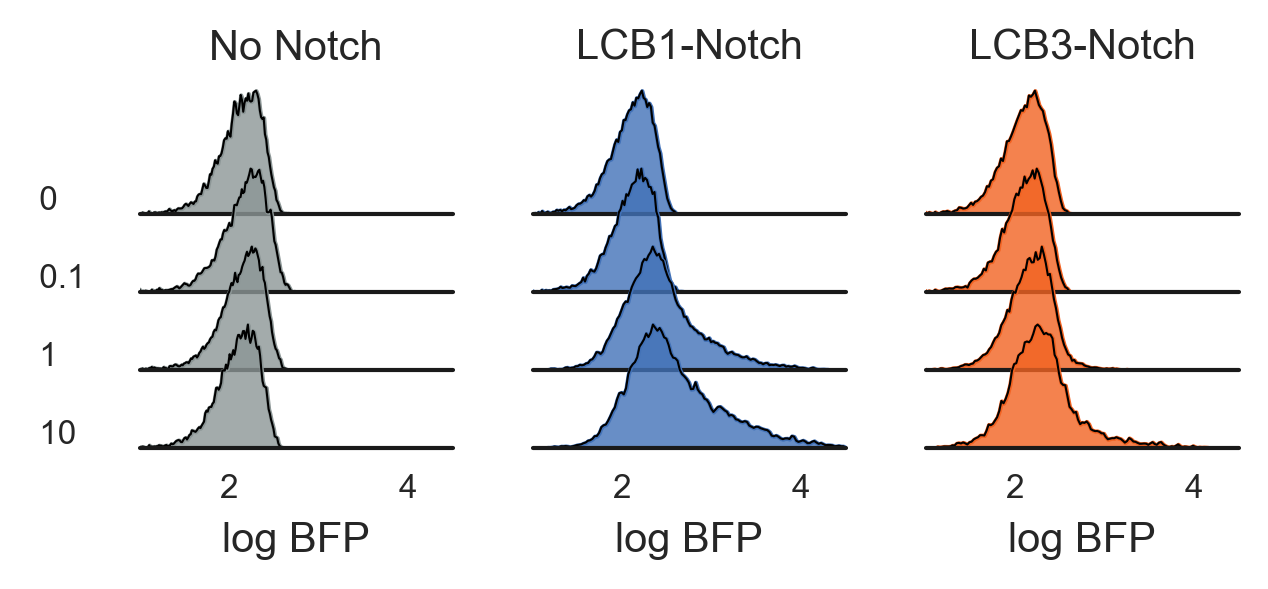

In [16]:
with sns.color_palette(["#8C9696", "#4272B8", "#F26322"]):
    doses = [str(x) for x in [0,0.1,1,10]]
    notches = ['No Notch', 'LCB1-Notch', 'LCB3-Notch']
    g = sns.FacetGrid(data=df2[(df2['logFITC-A'] > 4) &
                               (df2['Treatment'].isin(['PBS', 'Spike']))],
                      row='Dose', col='CellLine', hue='CellLine', sharey=False, aspect=3, height=0.45, 
                      row_order = doses,
                      hue_order = notches,
                      col_order = notches,
                      xlim=[1, 4.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)
    [ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]
    left_axes = [g.facet_axis(r, 0) for r in range(len(doses))]
    for ax in left_axes:
        dose = ax.get_title().split("=")[1].split('|')[0]
        ax.text(-0.35,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    
    g.set_titles("")
    top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
    for ax, notch in zip(top_axes, notches):
        ax.set_title(notch)

    # Remove axes details that don't play well with overlap
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.fig.set_dpi(300)
    g.set_xlabels("log BFP")
    #plt.suptitle('Jurkats', y=1.05)
    plt.savefig(outputdir+'jurkat_lcb3_histogram.svg')

In [19]:
filters = ((df2['logFITC-A'] > 4) &
           (df2['Treatment'].isin(['PBS', 'Spike'])))
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
summary = (df2[filters].groupby(['CellLine', 'Dose', 'Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())
summary['Dose'] = pd.to_numeric(summary['Dose'])

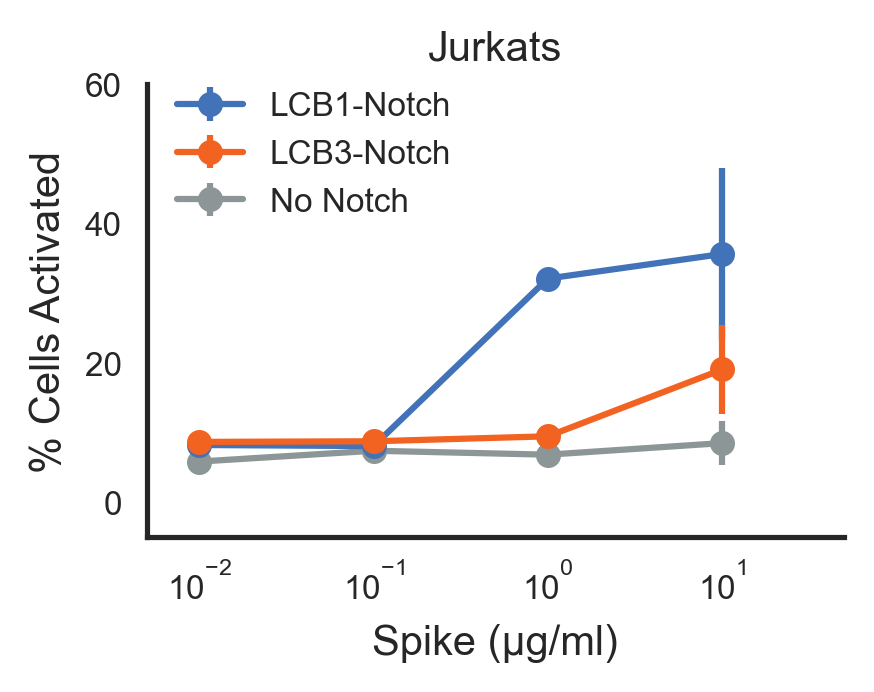

In [22]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for notch, color in zip(['No Notch', 'LCB1-Notch', 'LCB3-Notch'],['#8C9696',"#4272B8", '#F26322']):
    notch_summary = summary[(summary['CellLine']==notch) & (summary['Dose'] != 0)]
    output = notch_summary.groupby('Dose')['logBV 421-A'].agg([np.mean, np.std]).reset_index()
    ax.errorbar(output['Dose'], output['mean'], yerr=output['std'], fmt='-',marker='.', markersize=10, c=color, label=notch)

ax.set_xscale('log')
ax.set_xlim([0.005, 50])
ax.set_xlabel('Spike (µg/ml)')
ax.set_ylabel('% Cells Activated')
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [1, 2, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylim([-5,60])
sns.despine()
plt.title('Jurkats')
plt.savefig(outputdir + 'triplicate_dose.svg')